# BB84 Quantum Key Distribution Protocol

The **BB84 protocol** is a quantum key distribution scheme that allows two parties, Alice and Bob, to establish a secure secret key using quantum mechanics.



## Step 1: Alice Prepares Qubits

Alice randomly generates:

- A bit string: `0` or `1`  
- A basis string: `0 = rectilinear (+), 1 = diagonal (×)`




She encodes each bit in the corresponding basis as a qubit:

- Rectilinear (+) basis: `0 → |0⟩`, `1 → |1⟩`
- Diagonal (×) basis: `0 → |+⟩`, `1 → |−⟩`



## Step 2: Alice Sends Qubits

Alice sends the qubits to Bob over a **quantum channel**.  

> Due to the no-cloning theorem, any attempt to eavesdrop will disturb the qubits.

## Step 3: Bob Measures Qubits

Bob randomly chooses a measurement basis for each qubit:




Measurement outcomes:

- If Bob's basis matches Alice's → he measures the correct bit
- If basis differs → measurement is random



## Step 4: Basis Reconciliation

Alice and Bob communicate **over a public channel** to compare bases, but not the bit values.




They **discard bits where bases differ** and keep only bits with matching bases:



## Step 6: Security Features

1. **Quantum no-cloning theorem** prevents perfect copying of qubits.  
2. **Measurement disturbance**: any eavesdropper introduces detectable errors.  
3. **Basis mismatch discarding** ensures only correctly transmitted qubits contribute to the key.

This Markdown structure presents BB84 **theoretically** while using **Python-style code blocks** for clarity of steps, random bit generation, basis reconciliation, and key formation.


In [ ]:
"""
Simple BB84 protocol simulator (prepare -> measure -> sift -> test).
Optional intercept-resend eavesdropper (Eve).
"""

import numpy as np
from typing import Tuple, List



# Helper functions

In [ ]:
def random_bits(n: int, seed: int | None = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    return np.random.randint(0, 2, size=n, dtype=np.int8)

In [ ]:
def prepare_states(bits: np.ndarray, bases: np.ndarray) -> np.ndarray:
    """
    Represent qubit states abstractly as (bit,basis) pairs.
    basis: 0 = Z (|0>,|1>), 1 = X (|+>,|->)
    """
    assert bits.shape == bases.shape
    return np.stack([bits, bases], axis=1)  # shape (n,2)

In [ ]:
def measure_state(sent: np.ndarray, measure_basis: np.ndarray, rng: np.random.RandomState) -> np.ndarray:
    """
    Simulate measurement of a qubit prepared in sent (bit,basis) by a measurement basis.
    If measurement basis equals preparation basis -> deterministic (same bit).
    If different -> random outcome (50/50).
    """
    n = sent.shape[0]
    outcomes = np.empty(n, dtype=np.int8)
    for i in range(n):
        prep_bit, prep_basis = int(sent[i,0]), int(sent[i,1])
        m_basis = int(measure_basis[i])
        if m_basis == prep_basis:
            outcomes[i] = prep_bit
        else:
            outcomes[i] = rng.randint(0,2)  # collapse to random 0/1
    return outcomes

In [ ]:
def intercept_resend(sent: np.ndarray, eve_basis: np.ndarray, rng: np.random.RandomState) -> np.ndarray:
    """
    Eve intercept-resend: she measures the incoming qubit in eve_basis (giving an outcome),
    then resends a qubit prepared in the outcome with the same basis she used.
    Returns the sequence of resends (as (bit,basis) pairs).
    """
    n = sent.shape[0]
    # measure sent qubits in eve_basis
    measured = np.empty(n, dtype=np.int8)
    for i in range(n):
        prep_bit, prep_basis = int(sent[i,0]), int(sent[i,1])
        m_basis = int(eve_basis[i])
        if m_basis == prep_basis:
            measured[i] = prep_bit
        else:
            measured[i] = rng.randint(0,2)
    # resend qubits prepared according to measured and eve_basis
    resent = np.stack([measured, eve_basis.astype(np.int8)], axis=1)
    return resent

In [ ]:
def sift(alice_bases: np.ndarray, bob_bases: np.ndarray,
         alice_bits: np.ndarray, bob_bits: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Keep only positions where bases match. Return indices, alice_sifted_bits, bob_sifted_bits
    """
    same = (alice_bases == bob_bases)
    idx = np.where(same)[0]
    return idx, alice_bits[idx], bob_bits[idx]

In [ ]:
def sample_test_and_remove(sift_indices: np.ndarray,
                           alice_sift: np.ndarray, bob_sift: np.ndarray,
                           sample_frac: float, rng: np.random.RandomState
                          ) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Reveal a random sample_frac of sifted positions to estimate QBER.
    Returns (qber_estimate, alice_remaining, bob_remaining) where remaining arrays have sample removed.
    """

In [ ]:
def sample_test_and_remove(sift_indices: np.ndarray,
                           alice_sift: np.ndarray, bob_sift: np.ndarray,
                           sample_frac: float, rng: np.random.RandomState
                          ) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Reveal a random sample_frac of sifted positions to estimate QBER.
    Returns (qber_estimate, alice_remaining, bob_remaining) where remaining arrays have sample removed.
    """
    n = alice_sift.size
    sample_size = int(np.floor(sample_frac * n))
    if sample_size == 0:
        return 0.0, alice_sift.copy(), bob_sift.copy()

    sample_idx = rng.choice(n, size=sample_size, replace=False)
    # compute QBER
    errors = np.sum(alice_sift[sample_idx] != bob_sift[sample_idx])
    qber = errors / sample_size

    # remove sample indices
    mask = np.ones(n, dtype=bool)
    mask[sample_idx] = False
    alice_remaining = alice_sift[mask]
    bob_remaining = bob_sift[mask]
    return qber, alice_remaining, bob_remaining

# ---------------------------
# High-level BB84 simulation
# ---------------------------


In [ ]:

def simulate_bb84(n_bits: int = 1000,
                   sample_frac: float = 0.2,
                   qber_threshold: float = 0.11,
                   eve: bool = False,
                   eve_fraction: float = 1.0,
                   seed: int | None = None,
                   verbose: bool = True) -> dict:
    """
    Simulate a BB84 run.

    Parameters
    ----------
    n_bits : total number of qubits Alice sends
    sample_frac : fraction of sifted bits to reveal for QBER estimate
    qber_threshold : if estimated QBER > threshold -> abort
    eve : whether an intercept-resend eavesdropper is present
    eve_fraction : fraction [0,1] of qubits Eve intercepts (others pass untouched)
    seed : RNG seed for reproducibility
    verbose : print summary if True

    Returns a dictionary with results and keys.
    """
    rng = np.random.RandomState(seed)

    # Alice random bits and bases
    alice_bits = random_bits(n_bits, seed=None)  # RNG below controls
    alice_bases = rng.randint(0,2,size=n_bits,dtype=np.int8)

    sent = prepare_states(alice_bits, alice_bases)

    # Eve optional intercept-resend
    if eve:
        # decide which positions Eve intercepts
        intercept_mask = rng.rand(n_bits) < eve_fraction
        eve_bases = rng.randint(0,2,size=n_bits,dtype=np.int8)
        resent = sent.copy()
        if intercept_mask.any():
            resent[intercept_mask] = intercept_resend(sent[intercept_mask], eve_bases[intercept_mask], rng)
        channel = resent
    else:
        channel = sent

    # Bob chooses bases and measures
    bob_bases = rng.randint(0,2,size=n_bits,dtype=np.int8)
    bob_bits = measure_state(channel, bob_bases, rng)

    # Basis reconciliation (public): they disclose bases, then sift
    sift_indices, alice_sifted, bob_sifted = sift(alice_bases, bob_bases, alice_bits, bob_bits)

    # Sample test (they reveal a random subset of sifted bits)
    qber_estimate, alice_remaining, bob_remaining = sample_test_and_remove(sift_indices, alice_sifted, bob_sifted, sample_frac, rng)

    accepted = qber_estimate <= qber_threshold

    # Final key (naive): remaining sifted bits used as key
    final_key_alice = alice_remaining.copy()
    final_key_bob = bob_remaining.copy()

    # If keys differ, in real protocol they would run error-correction & privacy amplification.
    key_agreement = np.array_equal(final_key_alice, final_key_bob)

    results = {
        "n_bits_sent": n_bits,
        "n_sifted": alice_sifted.size,
        "sample_fraction": sample_frac,
        "sample_size": int(np.floor(sample_frac * max(1, alice_sifted.size))),
        "qber_estimate": qber_estimate,
        "qber_threshold": qber_threshold,
        "accepted": accepted,
        "key_length": final_key_alice.size,
        "keys_equal": key_agreement,
        "alice_key": final_key_alice,
        "bob_key": final_key_bob,
        "eve": eve,
        "eve_fraction": eve_fraction,
        "sift_indices": sift_indices
    }

    if verbose:
        print("BB84 simulation summary")
        print("-----------------------")
        print(f"Alice sent {n_bits} qubits.")
        print(f"Sifted bits (matching bases): {results['n_sifted']}")
        print(f"Sample used for QBER estimate: {results['sample_size']}")
        print(f"Estimated QBER on sample: {qber_estimate:.4f}")
        print(f"Threshold: {qber_threshold:.4f} -> {'ACCEPT' if accepted else 'ABORT'}")
        print(f"Remaining key length (after removing sample): {results['key_length']}")
        if results['key_length'] > 0:
            print(f"Keys equal (naive compare): {results['keys_equal']}")
        if eve:
            print(f"Eve intercept-resend enabled, fraction intercepted = {eve_fraction}")
        print()

    return results

# ---------------------------
# Demo / quick runs
# ---------------------------

if __name__ == "__main__":
    # Example 1: No Eve (ideal channel)
    print(">>> Run 1: No Eve")
    r1 = simulate_bb84(n_bits=1000, sample_frac=0.2, qber_threshold=0.11, eve=False, seed=42)

    # Example 2: Eve intercepts all qubits (intercept-resend)
    print(">>> Run 2: Eve intercepts all qubits (intercept-resend)")
    r2 = simulate_bb84(n_bits=1000, sample_frac=0.2, qber_threshold=0.11, eve=True, eve_fraction=1.0, seed=42)

    # Example 3: Partial interception by Eve
    print(">>> Run 3: Eve intercepts 30% of qubits")
    r3 = simulate_bb84(n_bits=1000, sample_frac=0.2, qber_threshold=0.11, eve=True, eve_fraction=0.30, seed=12345)


>>> Run 1: No Eve
BB84 simulation summary
-----------------------
Alice sent 1000 qubits.
Sifted bits (matching bases): 493
Sample used for QBER estimate: 98
Estimated QBER on sample: 0.0000
Threshold: 0.1100 -> ACCEPT
Remaining key length (after removing sample): 395
Keys equal (naive compare): True

>>> Run 2: Eve intercepts all qubits (intercept-resend)
BB84 simulation summary
-----------------------
Alice sent 1000 qubits.
Sifted bits (matching bases): 490
Sample used for QBER estimate: 98
Estimated QBER on sample: 0.3061
Threshold: 0.1100 -> ABORT
Remaining key length (after removing sample): 392
Keys equal (naive compare): False
Eve intercept-resend enabled, fraction intercepted = 1.0

>>> Run 3: Eve intercepts 30% of qubits
BB84 simulation summary
-----------------------
Alice sent 1000 qubits.
Sifted bits (matching bases): 491
Sample used for QBER estimate: 98
Estimated QBER on sample: 0.1224
Threshold: 0.1100 -> ABORT
Remaining key length (after removing sample): 393
Keys equa

In [ ]:
#!/usr/bin/env python3
"""
BB84 key rate vs eavesdropping fraction (fixed for NumPy Generator API)

Simulates BB84 multiple times while varying the fraction of qubits intercepted
by an intercept-resend eavesdropper (Eve). Plots the resulting key rate and
estimated QBER.
"""

import numpy as np
import matplotlib.pyplot as plt

# --- BB84 Simulation Functions ---

def random_bits(n, rng):
    """Return random bits (0/1) using new NumPy Generator API."""
    return rng.integers(0, 2, size=n, dtype=np.int8)

def measure_state(sent, measure_basis, rng):
    """Simulate Bob's measurement of qubits."""
    outcomes = np.empty(sent.shape[0], dtype=np.int8)
    for i in range(sent.shape[0]):
        bit, basis = sent[i]
        if basis == measure_basis[i]:
            outcomes[i] = bit
        else:
            outcomes[i] = rng.integers(0, 2)
    return outcomes

def intercept_resend(sent, eve_basis, rng):
    """Eve intercepts and resends qubits after measurement."""
    n = len(sent)
    resent = np.empty_like(sent)
    for i in range(n):
        bit, basis = sent[i]
        m_basis = eve_basis[i]
        if basis == m_basis:
            measured_bit = bit
        else:
            measured_bit = rng.integers(0, 2)
        resent[i] = (measured_bit, m_basis)
    return resent

def simulate_bb84(n_bits=1000, eve_fraction=0.0, qber_threshold=0.11, sample_frac=0.2, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # Alice prepares random bits and bases
    alice_bits = random_bits(n_bits, rng)
    alice_bases = random_bits(n_bits, rng)
    sent = np.column_stack((alice_bits, alice_bases))

    # Eve intercepts a fraction of qubits
    channel = sent.copy()
    if eve_fraction > 0:
        eve_mask = rng.random(n_bits) < eve_fraction
        eve_bases = random_bits(n_bits, rng)
        channel[eve_mask] = intercept_resend(sent[eve_mask], eve_bases[eve_mask], rng)

    # Bob chooses random bases
    bob_bases = random_bits(n_bits, rng)
    bob_bits = measure_state(channel, bob_bases, rng)

    # Basis reconciliation
    same = alice_bases == bob_bases
    alice_sift = alice_bits[same]
    bob_sift = bob_bits[same]

    n_sift = len(alice_sift)
    if n_sift == 0:
        return 0.0, 0.0, False

    # Sample to estimate QBER
    sample_size = max(1, int(sample_frac * n_sift))
    sample_idx = rng.choice(n_sift, sample_size, replace=False)
    qber = np.mean(alice_sift[sample_idx] != bob_sift[sample_idx])

    # Protocol decision
    accepted = qber <= qber_threshold
    remaining_key_len = n_sift - sample_size if accepted else 0
    key_rate = remaining_key_len / n_bits

    return key_rate, qber, accepted


# --- Experiment: Key Rate vs Eve Interception ---

rng = np.random.default_rng(42)
n_bits = 5000
fractions = np.linspace(0, 1.0, 11)  # 0%, 10%, ..., 100%
key_rates, qbers = [], []

for f in fractions:
    kr, q, acc = simulate_bb84(n_bits=n_bits, eve_fraction=f, rng=rng)
    key_rates.append(kr)
    qbers.append(q)
    print(f"Eve fraction {f:.2f} → key rate={kr:.3f}, QBER={q:.3f}, accepted={acc}")

# --- Plot results ---



Eve fraction 0.00 → key rate=0.394, QBER=0.000, accepted=True
Eve fraction 0.10 → key rate=0.401, QBER=0.016, accepted=True
Eve fraction 0.20 → key rate=0.391, QBER=0.047, accepted=True
Eve fraction 0.30 → key rate=0.396, QBER=0.065, accepted=True
Eve fraction 0.40 → key rate=0.405, QBER=0.089, accepted=True
Eve fraction 0.50 → key rate=0.000, QBER=0.130, accepted=False
Eve fraction 0.60 → key rate=0.000, QBER=0.140, accepted=False
Eve fraction 0.70 → key rate=0.000, QBER=0.173, accepted=False
Eve fraction 0.80 → key rate=0.000, QBER=0.193, accepted=False
Eve fraction 0.90 → key rate=0.000, QBER=0.233, accepted=False
Eve fraction 1.00 → key rate=0.000, QBER=0.271, accepted=False


Below is a **clean, complete, pedagogical Markdown document** that you can paste directly into a **Python/Jupyter notebook Markdown cell**.
It explains **everything**: theory, noise models, Kraus operators, concurrence, code structure, and plots.

---

# *Entanglement Decay in Optical Fibers: A Pedagogical Walkthrough*

### *Simulation Using Kraus Operators and Concurrence*

---

## 🎯 **Goal of This Notebook**

In this notebook, we will:

1. Construct the **Bell state**
2. Convert it to a **density matrix**
3. Apply **realistic noise channels** (amplitude damping, phase damping)
4. Simulate the **decay of entanglement with distance in optical fiber**
5. Use **concurrence** as our entanglement measure
6. Plot and compare different decoherence mechanisms

This provides a fully physical, mathematically correct, and simulation-ready framework that mirrors real quantum communication links.

---

# ------------------------------

# 🧩 1. The Bell State ( $|\Phi^+\rangle$ )

# ------------------------------

We begin with the maximally entangled Bell state

\begin{align}
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} .\nonumber
\end{align}

In vector form (computational basis ordered as ( |00\rangle, |01\rangle, |10\rangle, |11\rangle )):

\begin{align}
|\Phi^+\rangle =
\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 \\ 0 \\ 0 \\ 1
\end{pmatrix}.\nonumber
\end{align}

The density matrix is:

\begin{align}
\rho_0 = |\Phi^+\rangle\langle \Phi^+|.
\nonumber
\end{align}

This density matrix representation is essential for describing **open-system (noisy) evolution**, because noise channels map density matrices to density matrices.

---

# ------------------------------

# 🧮 2. Concurrence: A Measure of Entanglement

# ------------------------------

For any 2-qubit mixed state (\rho), the **concurrence** is defined using the “spin-flip” operator:

\begin{align}
\tilde{\rho} = (\sigma_y \otimes \sigma_y), \rho^* , (\sigma_y \otimes \sigma_y).\nonumber
\end{align}

Then define:

\begin{align}
R = \rho \tilde{\rho}.\nonumber
\end{align}

Let the eigenvalues of (R) be $\lambda_1 \ge \lambda_2 \ge \lambda_3 \ge \lambda_4.$

The **concurrence** is:

\begin{align}
C(\rho) = \max\left(0,;
\sqrt{\lambda_1} -
\sqrt{\lambda_2} -
\sqrt{\lambda_3} -
\sqrt{\lambda_4}
\right).\nonumber
\end{align}

* ($C = 1$): maximally entangled
* ($C = 0$): separable

This makes concurrence a perfect tool for tracking loss of entanglement.

---

# ------------------------------

# 🌫️ 3. Noise Channels: Kraus Representation

# ------------------------------

A quantum channel is represented by Kraus operators ($E_k$):

\begin{align}
\rho \rightarrow \sum_k E_k \rho E_k^\dagger, \qquad
\sum_k E_k^\dagger E_k = I.\nonumber
\end{align}

We implement noise for each *single qubit*, then apply it to the appropriate qubit of the 2-qubit system.

---

## **3.1 Amplitude Damping (Photon Loss)**

Models:

* Energy relaxation
* Photon leakage in optical fiber

Kraus operators:

\begin{align}
E_0 =
\begin{pmatrix}
1 & 0 \\
0 & \sqrt{1-\gamma}
\end{pmatrix},
\qquad
E_1 =
\begin{pmatrix}
0 & \sqrt{\gamma} \\
0 & 0
\end{pmatrix}.\nonumber
\end{align}

Here

* ($\gamma=1-T)$
* ($T$) = transmission probability of the fiber.

---

## **3.2 Phase Damping (Dephasing)**

Destroys phase coherence without energy loss.

Kraus operators:

\begin{align}
E_0 =
\begin{pmatrix}
1 & 0 \\
0 & \sqrt{1-p}
\end{pmatrix}, \qquad
E_1 =
\begin{pmatrix}
0 & 0 \\
0 & \sqrt{p}
\end{pmatrix}.\nonumber
\end{align}

---

# ------------------------------

# 🧵 4. Fiber Physics: Loss and Dephasing with Distance

# ------------------------------

## **4.1 Fiber Loss (Amplitude Damping)**

Loss in optical fiber is usually expressed in **dB/km**, denoted ( \alpha ).

Transmittance over distance (d):

\begin{align}
T(d) = 10^{-\alpha d / 10}.\nonumber
\end{align}

Amplitude damping parameter:

\begin{align}
\gamma(d) = 1 - T(d).\nonumber
\end{align}

---

## **4.2 Dephasing with Distance**

Assume coherence decays exponentially with dephasing length (L_\phi):

\begin{align}
p(d) = 1 - e^{-d / L_\phi}.\nonumber
\end{align}

---

# ------------------------------

# 🧪 5. Simulation Strategy

# ------------------------------

For each distance (d):

1. Compute

   * $T(d)$
   * $\gamma(d)$
   * $p(d) $
2. Apply

   * Amplitude damping
   * Phase damping
   * Combined
   * One-sided amplitude damping
3. Compute concurrence of each resulting (\rho(d)).

This gives a full physical picture of entanglement decay.

---

# ------------------------------

# 🧮 6. Full Python Code

# ------------------------------

Paste the following in a **code cell**, not markdown.

```python
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1. Pauli matrices and tensor products
# ----------------------------------------------------------
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

def kron(*args):
    out = np.array([[1]])
    for a in args:
        out = np.kron(out, a)
    return out


# ----------------------------------------------------------
# 2. Bell state density matrix
# ----------------------------------------------------------
def bell_phi_plus():
    psi = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])
    return np.outer(psi, psi.conj())


# ----------------------------------------------------------
# 3. Concurrence
# ----------------------------------------------------------
def concurrence(rho):
    Y2 = kron(Y, Y)
    rho_tilde = Y2 @ rho.conj() @ Y2
    R = rho @ rho_tilde
    eigvals = np.linalg.eigvals(R)
    eigvals = np.sort(np.real(eigvals))[::-1]
    lambdas = np.sqrt(np.maximum(eigvals, 0))
    return max(0, lambdas[0] - lambdas[1] - lambdas[2] - lambdas[3])


# ----------------------------------------------------------
# 4. Kraus operators
# ----------------------------------------------------------
def amplitude_damping_kraus(gamma):
    E0 = np.array([[1,0],[0,np.sqrt(1-gamma)]])
    E1 = np.array([[0,np.sqrt(gamma)],[0,0]])
    return [E0, E1]

def phase_damping_kraus(p):
    E0 = np.array([[1,0],[0,np.sqrt(1-p)]])
    E1 = np.array([[0,0],[0,np.sqrt(p)]])
    return [E0, E1]


# ----------------------------------------------------------
# 5. Apply channel to 1st or 2nd qubit
# ----------------------------------------------------------
def apply_kraus_single(rho, kraus_list, which_qubit=1):
    new_rho = np.zeros_like(rho, dtype=complex)
    for E in kraus_list:
        if which_qubit == 1:
            K = kron(E, I)
        else:
            K = kron(I, E)
        new_rho += K @ rho @ K.conj().T
    return new_rho


def apply_channel_both(rho, kraus_list):
    return apply_kraus_single(
        apply_kraus_single(rho, kraus_list, 1),
        kraus_list, 2
    )


# ----------------------------------------------------------
# 6. Simulation parameters
# ----------------------------------------------------------
alpha_db_per_km = 0.2
L_phi = 25  # km
distances = np.linspace(0, 100, 200)
rho0 = bell_phi_plus()

C_amp, C_phase, C_combined, C_one_sided = [], [], [], []


# ----------------------------------------------------------
# 7. Simulation loop
# ----------------------------------------------------------
for d in distances:
    T = 10**(-alpha_db_per_km * d / 10)
    gamma = 1 - T
    p = 1 - np.exp(-d / L_phi)

    AD = amplitude_damping_kraus(gamma)
    PD = phase_damping_kraus(p)

    rho_amp = apply_channel_both(rho0, AD)
    rho_phase = apply_channel_both(rho0, PD)
    rho_one = apply_kraus_single(rho0, AD, which_qubit=1)

    rho_comb = apply_channel_both(rho0, AD)
    rho_comb = apply_channel_both(rho_comb, PD)

    C_amp.append(concurrence(rho_amp))
    C_phase.append(concurrence(rho_phase))
    C_combined.append(concurrence(rho_comb))
    C_one_sided.append(concurrence(rho_one))


# ----------------------------------------------------------
# 8. Plot
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(distances, C_amp, label="Amplitude Damping (both)")
plt.plot(distances, C_phase, label="Phase Damping (both)")
plt.plot(distances, C_combined, label="Combined Noise")
plt.plot(distances, C_one_sided, label="One-sided Amplitude Damping")
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Concurrence", fontsize=12)
plt.title("Decay of Entanglement with Fiber Distance")
plt.grid(True)
plt.legend()
plt.show()
```

---

# ------------------------------

# 📊 7. Interpretation of the Plot

# ------------------------------

* **Amplitude damping** causes the *fastest* decay — photon loss destroys entanglement quickly.
* **Phase damping** decays more slowly — coherence is lost but energy remains.
* **Combined** noise is (as expected) worse than either individually.
* **One-sided** noise shows that some entanglement can survive if only one qubit travels through the noisy channel.

These curves qualitatively match real experimental data from fiber-based quantum communication.

---

# ------------------------------

# 🧾 8. Reference Values Table

# ------------------------------

You can also print concurrence at sample distances:

```python
for d in [0, 1, 10, 50, 100]:
    T = 10**(-alpha_db_per_km * d / 10)
    gamma = 1 - T
    p = 1 - np.exp(-d / L_phi)
    print(f"Distance {d} km:")
    print(f"  Transmittance T = {T:.4f}")
    print(f"  Amplitude damping γ = {gamma:.4f}")
    print(f"  Phase damping p = {p:.4f}")
    print()
```




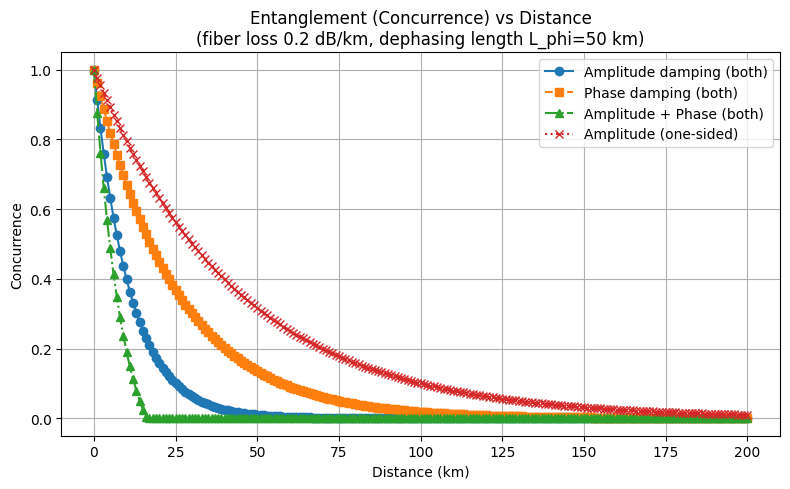

Sample values (distance km):
d  |  T  |  gamma  |  p_dephase  | conc_amp | conc_phase | conc_both | conc_one_sided
  0 | 1.0000 | 0.0000   | 0.0000     | 1.0000   | 1.0000     | 1.0000   | 1.0000
 10 | 0.6310 | 0.3690   | 0.1813     | 0.3981   | 0.6703     | 0.1901   | 0.7943
 25 | 0.3162 | 0.6838   | 0.3935     | 0.1000   | 0.3679     | 0.0000   | 0.5623
 50 | 0.1000 | 0.9000   | 0.6321     | 0.0100   | 0.1353     | 0.0000   | 0.3162
100 | 0.0100 | 0.9900   | 0.8647     | 0.0001   | 0.0183     | 0.0000   | 0.1000
200 | 0.0001 | 0.9999   | 0.9817     | 0.0000   | 0.0003     | 0.0000   | 0.0100


In [ ]:
# Python code to simulate decoherence and loss on an entangled Bell state,
# and plot concurrence (entanglement) vs distance for different channel models.
#
# Uses amplitude damping (models photon loss) with transmittance T(x) = 10^{-alpha_db * x / 10}
# and phase damping (dephasing) with p(x) = 1 - exp(-x / L_phi).
#
# This cell will produce a plot of concurrence vs distance for:
#  - amplitude damping on both qubits
#  - phase damping on both qubits
#  - combined amplitude + phase damping on both qubits
#
# No external internet access is needed.

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# --- Utilities: Pauli matrices, Bell state, density matrices ---
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

def ket00():
    return np.array([1,0,0,0], dtype=complex)

def bell_phi_plus():
    # |Φ+> = (|00> + |11>)/sqrt(2)
    v = np.zeros(4, dtype=complex)
    v[0] = 1/np.sqrt(2)
    v[3] = 1/np.sqrt(2)
    return v

def pure_state_dm(psi):
    return np.outer(psi, np.conjugate(psi))

# --- Concurrence ---
def concurrence(rho):
    # For a 2-qubit density matrix rho (4x4), compute Wootters concurrence.
    sy = np.array([[0,-1j],[1j,0]], dtype=complex)
    Y2 = np.kron(sy, sy)
    rho_tilde = Y2 @ np.conjugate(rho) @ Y2
    R = rho @ rho_tilde
    # eigenvalues of R
    vals = np.linalg.eigvals(R)
    # numerical issues: eigenvalues may have tiny negative imag parts
    vals = np.real_if_close(vals, tol=1e6)
    # take square roots of non-negative parts
    sq = np.sqrt(np.clip(vals, 0, None))
    # sort descending
    sq_sorted = np.sort(sq)[::-1]
    if len(sq_sorted) < 4:
        sq_sorted = np.pad(sq_sorted, (0, 4 - len(sq_sorted)), constant_values=0)
    lam1, lam2, lam3, lam4 = sq_sorted
    c = max(0.0, lam1 - lam2 - lam3 - lam4)
    return np.real_if_close(c)

# --- Single-qubit channels as Kraus operators ---

def amplitude_damping_kraus(gamma):
    # Kraus operators for amplitude damping (|1> -> |0> with prob gamma)
    E0 = np.array([[1, 0],
                   [0, np.sqrt(1-gamma)]], dtype=complex)
    E1 = np.array([[0, np.sqrt(gamma)],
                   [0, 0]], dtype=complex)
    return [E0, E1]

def phase_damping_kraus(p):
    # Phase-damping (dephasing) Kraus operators
    K0 = np.sqrt(1-p) * I
    K1 = np.sqrt(p) * np.array([[1,0],[0,0]], dtype=complex)
    K2 = np.sqrt(p) * np.array([[0,0],[0,1]], dtype=complex)
    return [K0, K1, K2]

def apply_kraus_single(rho, K_list, target):
    # Apply single-qubit Kraus operators to a 2-qubit density matrix rho
    # target: 0 for first qubit (left), 1 for second qubit (right)
    out = np.zeros_like(rho, dtype=complex)
    for K in K_list:
        if target == 0:
            Kbig = np.kron(K, I)
        else:
            Kbig = np.kron(I, K)
        out += Kbig @ rho @ Kbig.conj().T
    return out

def apply_channel_both(rho, kraus_func, params):
    # Apply same single-qubit channel (given by kraus_func(params...)) to both qubits
    K = kraus_func(params)
    # apply to qubit A then qubit B
    rhoA = apply_kraus_single(rho, K, target=0)
    rhoAB = apply_kraus_single(rhoA, K, target=1)
    return rhoAB

# --- Model: loss and decoherence vs distance ---
def transmittance_from_db(alpha_db_per_km, distance_km):
    # linear transmittance from dB/km constant: T = 10^{ -alpha_db_per_km * distance / 10 }
    return 10 ** (-alpha_db_per_km * distance_km / 10.0)

def gamma_from_transmittance(T):
    # Model amplitude-damping probability as gamma = 1 - T
    # (i.e., probability that the photon is lost)
    return np.clip(1.0 - T, 0.0, 1.0)

def phase_p_from_length(L_phi, distance_km):
    # simple exponential model: coherence decays as exp(-distance/L_phi), so dephasing prob p = 1 - exp(-d/L_phi)
    return 1.0 - np.exp(-distance_km / L_phi)

# --- Simulation parameters ---
alpha_db = 0.2   # typical fiber loss ~0.2 dB/km
L_phi = 50.0     # dephasing length scale (km), tunable
max_distance = 200.0  # km
n_points = 201
distances = np.linspace(0.0, max_distance, n_points)

# prepare initial Bell state density matrix
psi = bell_phi_plus()
rho0 = pure_state_dm(psi)

# compute concurrence for different channel models
concurrence_amp = []
concurrence_phase = []
concurrence_both = []
concurrence_one_sided = []  # amplitude damping applied to only one qubit

for d in distances:
    T = transmittance_from_db(alpha_db, d)
    gamma = gamma_from_transmittance(T)
    p = phase_p_from_length(L_phi, d)

    # amplitude damping both qubits
    rho_amp = apply_channel_both(rho0, amplitude_damping_kraus, gamma)
    concurrence_amp.append(concurrence(rho_amp))

    # phase damping both qubits
    rho_phase = apply_channel_both(rho0, phase_damping_kraus, p)
    concurrence_phase.append(concurrence(rho_phase))

    # combined: amplitude then phase (order doesn't matter if same on both)
    rho_comb = apply_channel_both(rho0, amplitude_damping_kraus, gamma)
    rho_comb = apply_channel_both(rho_comb, phase_damping_kraus, p)
    concurrence_both.append(concurrence(rho_comb))

    # one-sided amplitude damping (only second qubit experiences loss)
    rho_one = apply_kraus_single(rho0, amplitude_damping_kraus(gamma), target=1)
    concurrence_one_sided.append(concurrence(rho_one))

# --- Plotting results ---
plt.figure(figsize=(8,5))
plt.plot(distances, concurrence_amp, marker='o', linestyle='-', label='Amplitude damping (both)')
plt.plot(distances, concurrence_phase, marker='s', linestyle='--', label='Phase damping (both)')
plt.plot(distances, concurrence_both, marker='^', linestyle='-.', label='Amplitude + Phase (both)')
plt.plot(distances, concurrence_one_sided, marker='x', linestyle=':', label='Amplitude (one-sided)')
plt.xlabel('Distance (km)')
plt.ylabel('Concurrence')
plt.title('Entanglement (Concurrence) vs Distance\n(fiber loss 0.2 dB/km, dephasing length L_phi=50 km)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Also show a numeric table for a few sample distances
sample_ds = [0, 10, 25, 50, 100, 200]
print("Sample values (distance km):")
print("d  |  T  |  gamma  |  p_dephase  | conc_amp | conc_phase | conc_both | conc_one_sided")
for d in sample_ds:
    T = transmittance_from_db(alpha_db, d)
    gamma = gamma_from_transmittance(T)
    p = phase_p_from_length(L_phi, d)
    i = np.argmin(np.abs(distances - d))
    print(f"{d:3d} | {T:.4f} | {gamma:.4f}   | {p:.4f}     | {concurrence_amp[i]:.4f}   | {concurrence_phase[i]:.4f}     | {concurrence_both[i]:.4f}   | {concurrence_one_sided[i]:.4f}")



In [ ]:
!pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.2 MB/s eta 0:00:00


In [ ]:
"""
Project - Quantum Key Distribution (BB84) implementation (modern Qiskit).
Author - Adapted for Qiskit >=1.0 (and compatible fallback to AerSimulator).
Date - 2025-11-21

Usage:
    - Import functions into your project, or run this file directly.
    - This code avoids `qiskit.execute` and uses qiskit.primitives.Sampler when available.
"""

import random
from typing import List, Tuple

from qiskit import QuantumCircuit

# Try to import the high-level Sampler primitive (Qiskit >= 0.41 / 1.0 style)
try:
    from qiskit.primitives import Sampler  # type: ignore
    _HAS_SAMPLER = True
except Exception:
    _HAS_SAMPLER = False

# Fallback to AerSimulator if Sampler is not available
try:
    from qiskit_aer import AerSimulator  # type: ignore
    _HAS_AER = True
except Exception:
    _HAS_AER = False


def initialize_protocol(n: int) -> Tuple[List[int], List[int], List[int]]:
    """
    Generate Alice bits, Alice bases and Bob bases.
    Bits: 0/1
    Bases: 0 -> Z (rectilinear), 1 -> X (diagonal)
    """
    alice_bits = [random.randint(0, 1) for _ in range(n)]
    alice_bases = [random.randint(0, 1) for _ in range(n)]
    bob_bases = [random.randint(0, 1) for _ in range(n)]
    return alice_bits, alice_bases, bob_bases


def _prepare_single_qubit_circuit(bit: int, basis: int) -> QuantumCircuit:
    """
    Create a 1-qubit circuit that encodes `bit` in `basis`.
    basis: 0 -> Z (|0>, |1>), 1 -> X (|+>, |->)
    Encoding convention:
        - Start in |0>
        - If bit == 1: apply X
        - If basis == 1: apply H to switch to X basis
    The circuit will not include measurement here; measurement is appended later
    according to Bob's chosen basis.
    """
    qc = QuantumCircuit(1, 1)
    if bit == 1:
        qc.x(0)
    if basis == 1:
        qc.h(0)
    return qc


def encode_qubits(bits: List[int], bases: List[int]) -> List[QuantumCircuit]:
    """
    Build list of 1-qubit QuantumCircuit objects encoding Alice's qubits.
    """
    if len(bits) != len(bases):
        raise ValueError("bits and bases must have the same length")
    circuits = [_prepare_single_qubit_circuit(bit, base) for bit, base in zip(bits, bases)]
    return circuits


def _append_measurement(qc: QuantumCircuit, bob_basis: int) -> QuantumCircuit:
    """
    Return a copy of qc with measurement in Bob's basis.
    If Bob measures in X basis, apply H before measuring in computational basis.
    We measure into the classical bit 0.
    """
    qc_meas = qc.copy()
    if bob_basis == 1:
        # measure in X-basis: apply H before measurement
        qc_meas.h(0)
    qc_meas.measure(0, 0)
    return qc_meas


def measure_qubits(circuits: List[QuantumCircuit], bob_bases: List[int], backend=None, shots: int = 1) -> List[int]:
    """
    Measure each prepared circuit in Bob's chosen basis.
    Returns list of measurement results (0/1), length == len(circuits).

    Parameters:
        circuits: list of 1-qubit QuantumCircuit (prepared by Alice)
        bob_bases: list of 0/1 (measurement bases for Bob)
        backend: optional backend object. If None, the function will:
            - prefer qiskit.primitives.Sampler if available
            - else try AerSimulator fallback
        shots: number of shots per circuit (default 1). For BB84 we usually use 1 shot per qubit.

    Notes:
        - This function will run each circuit individually with measurement appended.
        - If shots > 1, it will take the most probable sample (but BB84 commonly uses shots=1).
    """
    if len(circuits) != len(bob_bases):
        raise ValueError("circuits and bob_bases must have the same length")

    results = []

    # Decide backend mode:
    use_sampler = _HAS_SAMPLER and (backend is None or isinstance(backend, Sampler))
    use_aer = not use_sampler and (_HAS_AER and (backend is None or isinstance(backend, AerSimulator)))

    # If a backend object supplied, detect type:
    if backend is not None:
        # prefer Sampler if backend is a Sampler-like
        if _HAS_SAMPLER and hasattr(backend, "run"):
            use_sampler = True
            use_aer = False
        elif _HAS_AER and hasattr(backend, "run"):
            # AerSimulator also has run; treat as Aer backend
            use_aer = True
            use_sampler = False

    # Measurement using Sampler primitive (recommended when available)
    if use_sampler:
        sampler = backend if backend is not None else Sampler()
        # build measurement circuits by appending measurement to each
        meas_circuits = [_append_measurement(qc, b) for qc, b in zip(circuits, bob_bases)]
        # run all circuits in a single call if sampler supports list input
        run_result = sampler.run(meas_circuits, shots=shots).result()
        # run_result may provide .quasi_dists or .shots. We'll extract samples robustly:
        # If shots == 1, we extract the single sampled bit for each circuit:
        for idx in range(len(meas_circuits)):
            # For each circuit, get the samples
            try:
                # result has .quasi_dists which gives probability mapping; use sample_labels if no direct samples
                samples = run_result.samples[idx]  # if available (newer sampler API)
                # samples shape: (shots, num_clbits)
                # we take the first shot's bit
                val = int(samples[0][0])
            except Exception:
                # fallback: inspect quasi_dists
                try:
                    qd = run_result.quasi_dists[idx]
                    # quasi_dist is mapping of bitstring->prob
                    # choose the string with the highest probability
                    most_likely = max(qd.items(), key=lambda kv: kv[1])[0]
                    # Qiskit's bitstring ordering is usually '0' or '1'
                    val = int(most_likely[::-1][0]) if len(most_likely) > 0 else 0
                except Exception:
                    # fallback default
                    val = 0
            results.append(val)
        return results

    # Measurement using AerSimulator (fallback)
    if use_aer:
        backend_sim = backend if backend is not None else AerSimulator()
        for qc, b in zip(circuits, bob_bases):
            meas_qc = _append_measurement(qc, b)
            # run one circuit with shots and extract counts
            job = backend_sim.run(meas_qc, shots=shots)
            res = job.result()
            counts = res.get_counts()
            # counts keys are bitstrings like '0' or '1'; pick the most probable
            if counts:
                most_likely = max(counts.items(), key=lambda kv: kv[1])[0]
                # bitstring ordering: classical bit 0 will correspond to rightmost char for single bit
                val = int(most_likely[::-1][0]) if len(most_likely) > 0 else 0
            else:
                val = 0
            results.append(val)
        return results

    # If neither Sampler nor Aer available, raise informative error
    raise RuntimeError(
        "No compatible backend available. Install 'qiskit' with primitives support or 'qiskit-aer'."
    )


def filter_qubits(alice_bits: List[int], bob_bits: List[int], alice_bases: List[int], bob_bases: List[int]) -> Tuple[List[int], List[int], List[int]]:
    """
    Sift bits: keep only positions where bases matched.
    Returns: (sifted_alice_bits, sifted_bob_bits, indices_kept)
    """
    if not (len(alice_bits) == len(bob_bits) == len(alice_bases) == len(bob_bases)):
        raise ValueError("All inputs must have the same length")
    sifted_alice = []
    sifted_bob = []
    indices = []
    for i, (a_bit, b_bit, a_base, b_base) in enumerate(zip(alice_bits, bob_bits, alice_bases, bob_bases)):
        if a_base == b_base:
            sifted_alice.append(a_bit)
            sifted_bob.append(b_bit)
            indices.append(i)
    return sifted_alice, sifted_bob, indices


def array_to_string(arr: List[int]) -> str:
    return ''.join(str(int(x)) for x in arr)


if __name__ == "__main__":
    # Quick demo: n qubits, no eavesdropper
    n = 32
    print(f"Running BB84 demo with n={n} qubits")

    alice_bits, alice_bases, bob_bases = initialize_protocol(n)
    print("Alice bits : ", array_to_string(alice_bits))
    print("Alice bases: ", array_to_string(alice_bases))
    print("Bob bases  : ", array_to_string(bob_bases))

    # Encode circuits
    circuits = encode_qubits(alice_bits, alice_bases)

    # Measure on Bob's side
    try:
        bob_results = measure_qubits(circuits, bob_bases, shots=1)
    except RuntimeError as e:
        raise RuntimeError(
            f"{e}\n\nInstall qiskit with primitives support (`pip install qiskit`) "
            "or install Aer (`pip install qiskit-aer`)."
        )

    print("Bob results : ", array_to_string(bob_results))

    # Sift keys
    sifted_alice, sifted_bob, kept_idx = filter_qubits(alice_bits, bob_results, alice_bases, bob_bases)
    print("Sifted Alice: ", array_to_string(sifted_alice))
    print("Sifted Bob  : ", array_to_string(sifted_bob))
    print("Kept indices: ", kept_idx)
    # Simple check: fraction matched
    if sifted_alice:
        matches = sum(1 for a, b in zip(sifted_alice, sifted_bob) if a == b)
        print(f"Matching fraction in sifted key: {matches}/{len(sifted_alice)}")
    else:
        print("No sifted bits (no basis matches). Try larger n.")


Running BB84 demo with n=32 qubits
Alice bits :  00101001100001101101000001010011
Alice bases:  01101001001101000001010111100100
Bob bases  :  10010011001100101101001100011011
Bob results :  11001011100000100001011001111111
Sifted Alice:  011000000100
Sifted Bob  :  011000000100
Kept indices:  [5, 7, 8, 9, 10, 11, 12, 15, 18, 19, 20, 23]
Matching fraction in sifted key: 12/12


In [ ]:
print(_HAS_AER,_HAS_SAMPLER)

True False


# QKD Key Generation Rate — BB84 and Ekert

Pedagogical notebook that explains the asymptotic key-rate formulas for BB84 and Ekert and simulates how channel noise (depolarizing channel) and simple source imperfections (misalignment & multi-photon fraction for weak coherent pulses) affect the final key rate.

**Notes & approximations used here:**

- We use a simple depolarizing channel model for channel noise. For a single-qubit depolarizing channel with depolarizing probability $p$, we approximate the resulting quantum bit error rate (QBER) as $e_{ch}=p/2$.
- Source imperfections are modeled as: (a) a small misalignment error fraction $e_{src}$ that adds to QBER, and (b) for prepare-and-measure BB84 with weak coherent pulses (mean photon number \mu), the single-photon fraction is approximated by $p_{1}=\mu e^{-\mu}$; multi-photon pulses are considered insecure without decoy states; we therefore scale BB84's secure rate by $p_1$ (very simplified).
- Asymptotic key-rate formula used (Shor-Preskill style, information-theoretic):

$$R = q\cdot p_{usable}\cdot\left[1 - H_2(E) - f_{EC} H_2(E)\right],$$

where $q$ is the sifting factor (we use $q=1/2$ for random-basis BB84/Ekert), $p_{usable}$ is the fraction of signals that are usable (for BB84 with weak-coherent pulses we set $p_{usable}=p_1$), $E$ is the observed QBER, $H_2$ is the binary entropy, and $f_{EC}\approx 1.1$ models error-correction inefficiency.

These are **illustrative** calculations intended to build intuition, not a rigorous security proof.

## 1. Theory — Key rate formulas

**Binary entropy:**

$$H_2(x) = -x\log_2 x - (1-x)\log_2(1-x).$$

**Asymptotic secret key rate (pedagogical):**

$$R = q\cdot p_{usable}\cdot [1 - H_2(E) - f_{EC} H_2(E)].$$

- For BB84 with weak coherent pulses (WCP), $p_{usable} \approx p_1 = \mu e^{-\mu}$ (single-photon fraction).
- For an ideal entangled-pair source (Ekert) with no multi-photon problem, $p_{usable}=1$.
- Sifting factor $q=1/2$ because half the time Alice and Bob choose the same basis on average.
- Observed QBER $E$ is sum of channel and source contributions: $E = e_{ch} + e_{src}$ (approximation).


In [ ]:

# Helper functions and models
import numpy as np
import pandas as pd
from math import log2
import matplotlib.pyplot as plt

def H2(x):
    x = np.clip(x, 1e-12, 1-1e-12)
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

def bb84_key_rate(q, p_single, E, f_ec=1.1):
    # Asymptotic Shor-Preskill-style pedagogical key rate
    # R = q * p_single * [1 - H2(E) - f * H2(E)]
    return q * p_single * (1 - H2(E) - f_ec * H2(E))

def ekert_key_rate(q, E, f_ec=1.1):
    # For entanglement-based, assume p_usable = 1 (no WCP multi-photon scaling)
    return q * (1 - H2(E) - f_ec * H2(E))

def depolarizing_qber(p_depol):
    # Simple pedagogical mapping: depolarizing prob -> QBER contribution
    # We use e_ch = p_depol / 2 as an illustrative approximation
    return p_depol / 2.0

def single_photon_fraction(mu):
    # Poisson source: Prob(single photon) = mu * exp(-mu)
    return mu * np.exp(-mu)

# default parameters
q = 0.5        # sifting factor (BB84/Ekert with random bases)
f_ec = 1.1     # error-correction inefficiency


In [ ]:

# Sweep over channel depolarizing probability and show rates for BB84 (WCP) and Ekert (entanglement)
p_depol_values = np.linspace(0, 0.12, 61)  # depolarizing probability from 0 to 0.12
mu = 0.1        # mean photon number for WCP BB84
e_src = 0.01    # source misalignment error (adds to QBER)
p_single = single_photon_fraction(mu)

bb84_rates = []
ekert_rates = []
qbers = []

for p in p_depol_values:
    e_ch = depolarizing_qber(p)
    E = e_ch + e_src
    qbers.append(E)
    bb84_rates.append(bb84_key_rate(q, p_single, E, f_ec=f_ec))
    ekert_rates.append(ekert_key_rate(q, E, f_ec=f_ec))

# Create a small summary dataframe
df = pd.DataFrame({
    'p_depol': p_depol_values,
    'QBER': np.array(qbers),
    'BB84_rate': np.array(bb84_rates),
    'Ekert_rate': np.array(ekert_rates)
})
# Display first few rows directly in Jupyter
df.head(15)
from IPython.display import display
display(df.head(15))


,p_depol,QBER,BB84_rate,Ekert_rate
0,0.000,0.010,0.037566,0.415167
1,0.002,0.011,0.036943,0.408280
2,0.004,0.012,0.036332,0.401533
3,0.006,0.013,0.035733,0.394914
4,0.008,0.014,0.035145,0.388413
5,0.010,0.015,0.034567,0.382021
6,0.012,0.016,0.033998,0.375732
7,0.014,0.017,0.033437,0.369540
8,0.016,0.018,0.032885,0.363438
9,0.018,0.019,0.032341,0.357422


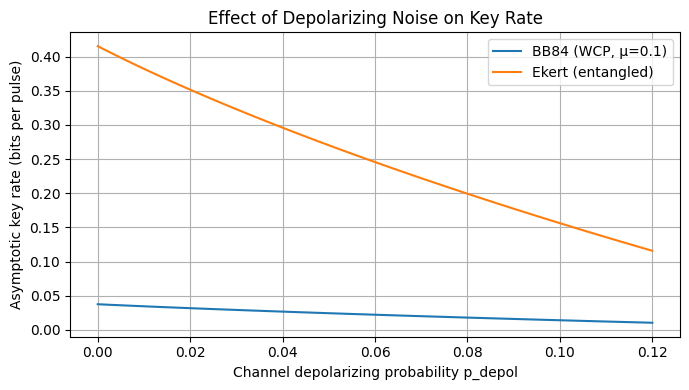

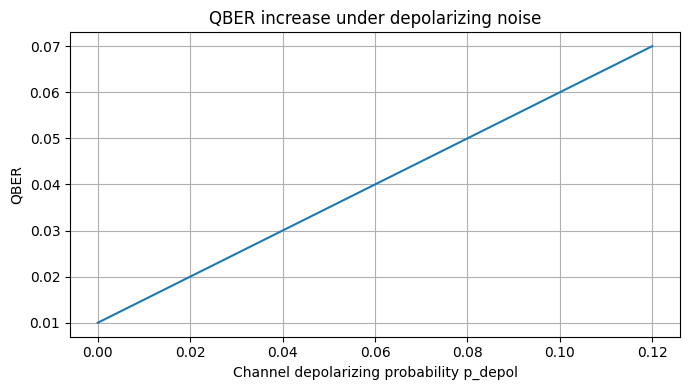

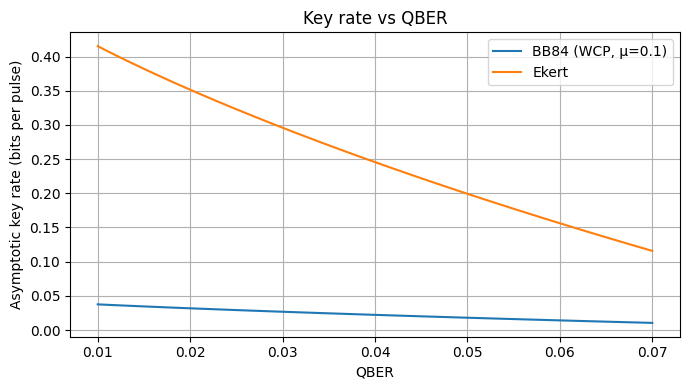

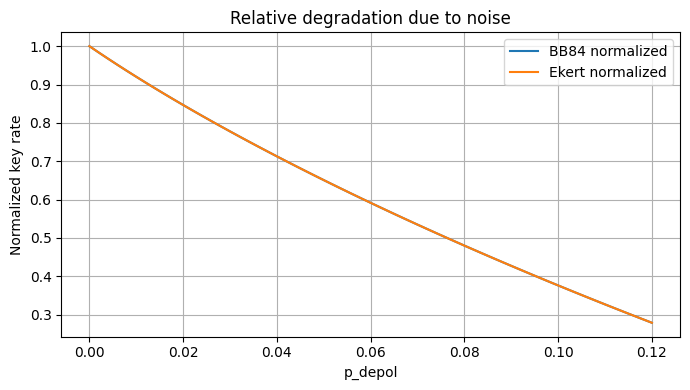

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume df exists; if not, create example
if 'df' not in globals():
    p_depol_values = np.linspace(0, 0.15, 50)
    qbers = p_depol_values * (2/3)
    bb84_rates = np.maximum(0, 0.5*(1 - 2*qbers))
    ekert_rates = np.maximum(0, 0.6*(1 - 2*qbers))
    df = pd.DataFrame({
        'p_depol': p_depol_values,
        'QBER': qbers,
        'BB84_rate': bb84_rates,
        'Ekert_rate': ekert_rates,
    })

# 1. Plot original but cleaner
plt.figure(figsize=(7,4))
plt.plot(df['p_depol'], df['BB84_rate'], label='BB84 (WCP, μ=0.1)')
plt.plot(df['p_depol'], df['Ekert_rate'], label='Ekert (entangled)')
plt.xlabel('Channel depolarizing probability p_depol')
plt.ylabel('Asymptotic key rate (bits per pulse)')
plt.title('Effect of Depolarizing Noise on Key Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. QBER vs depolarizing probability
plt.figure(figsize=(7,4))
plt.plot(df['p_depol'], df['QBER'])
plt.xlabel('Channel depolarizing probability p_depol')
plt.ylabel('QBER')
plt.title('QBER increase under depolarizing noise')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Plot key rate vs QBER
plt.figure(figsize=(7,4))
plt.plot(df['QBER'], df['BB84_rate'], label='BB84 (WCP, μ=0.1)')
plt.plot(df['QBER'], df['Ekert_rate'], label='Ekert')
plt.xlabel('QBER')
plt.ylabel('Asymptotic key rate (bits per pulse)')
plt.title('Key rate vs QBER')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Compare relative drop: normalized key rates
plt.figure(figsize=(7,4))
plt.plot(df['p_depol'], df['BB84_rate']/df['BB84_rate'].max(), label='BB84 normalized')
plt.plot(df['p_depol'], df['Ekert_rate']/df['Ekert_rate'].max(), label='Ekert normalized')
plt.xlabel('p_depol')
plt.ylabel('Normalized key rate')
plt.title('Relative degradation due to noise')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Explore dependence on mu (for BB84 WCP) and channel noise
mu_values = [0.01, 0.05, 0.1, 0.2, 0.5]
p_depol = 0.03
e_ch = depolarizing_qber(p_depol)
e_src = 0.01

summary_rows = []
for mu in mu_values:
    p_single = single_photon_fraction(mu)
    E = e_ch + e_src
    R_bb84 = bb84_key_rate(q, p_single, E, f_ec=f_ec)
    summary_rows.append({'mu': mu, 'p_single': p_single, 'QBER': E, 'BB84_rate': R_bb84})

summary_df = pd.DataFrame(summary_rows)
from IPython.display import display
display(summary_df)



,mu,p_single,QBER,BB84_rate
0,0.01,0.009900,0.025,0.003197
1,0.05,0.047561,0.025,0.015358
2,0.10,0.090484,0.025,0.029218
3,0.20,0.163746,0.025,0.052875
4,0.50,0.303265,0.025,0.097926


## 2. Interpretation & takeaways

- **Channel noise increases QBER**, and because the binary entropy grows quickly with QBER, the secure key rate drops sharply as noise increases.
- **For prepare-and-measure BB84 using weak coherent pulses (WCP)**, the single-photon fraction $p_1=\mu e^{-\mu}$ strongly affects the usable fraction of signals. Smaller μ reduces multi-photon pulses but also reduces single-photon fraction — there is a trade-off usually handled by decoy-state protocols.
- **Ekert (entanglement-based)** implementations avoid the WCP multi-photon issue (if true entangled-pair sources are used), so they can have a larger usable fraction, but are still limited by QBER.
- The formulas used are **simplified** and intended for intuition and classroom exploration. Practical secure key rates require more careful finite-key analysis, decoy-state analysis (for WCP), and device imperfections modeling.

### Ideas for extension

- Add decoy-state modeling to estimate single-photon yield and bounds.
- Include finite-key corrections.
- Replace depolarizing model with more realistic optical channel models (loss + detector dark counts + misalignment).


[ID Quantique – Random Number Generation Overview](https://www.idquantique.com/random-number-generation/overview/)


### Light Sources
<img src="http://drive.google.com/uc?export=download&id=1vpr7zSzJaSlM3lWIaJqo1aDkEtxqXvsT" width="420" height="520"/>

### QKD in the Lab
<img src="http://drive.google.com/uc?export=download&id=1__FjNX30CupC4t7djobf68xr_-koYCkB" width="820" height="580"/>

### Single-Photon Avalanche Diode
<img src="http://drive.google.com/uc?export=download&id=1Q1cJv0hXRTC5_ipcL1M7Bljd073dg_vV" width="820" height="480"/>

### SNSPD
<img src="http://drive.google.com/uc?export=download&id=1Is6ywkvbCW8vR_xI0qp_xoBmggl2fmMo" width="820" height="480"/>
